# Data Vectorization

In [1]:
import sys
sys.path.append('../')
import numpy as np
import pandas as pd
import spacy
import umap
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from helper_functions import plot_embeddings

2025-12-17 23:59:33.407683: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
datascience_posts_df = pd.read_csv("../Data Science Posts.csv").set_index('Id')
datascience_posts_df['is_question'] = datascience_posts_df['PostTypeId'] == 1

## Text Data

In [3]:
text_df = datascience_posts_df[datascience_posts_df['is_question']]
vectorizer = TfidfVectorizer(ngram_range = (1, 2), min_df = 5)
datascience_posts_BOW = vectorizer.fit_transform(text_df['body_text'])

# Extracting the sentence labels
sentence_labels = text_df['AcceptedAnswerId'].notna()

### Using one of Spacy's large models

In [4]:
spacy_NLP = spacy.load('en_core_web_lg', disable = ['parser', 'tagger', 'ner', 'textcat'])
spacy_embeddings = text_df['body_text'].apply(lambda x: spacy_NLP(x).vector)

/anaconda/envs/azureml_py38/lib/python3.10/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


## Dimensional Reduction Using UMAP

In [5]:
UMAP_embedding = umap.UMAP()

### Bag-Of-Words (BOW)

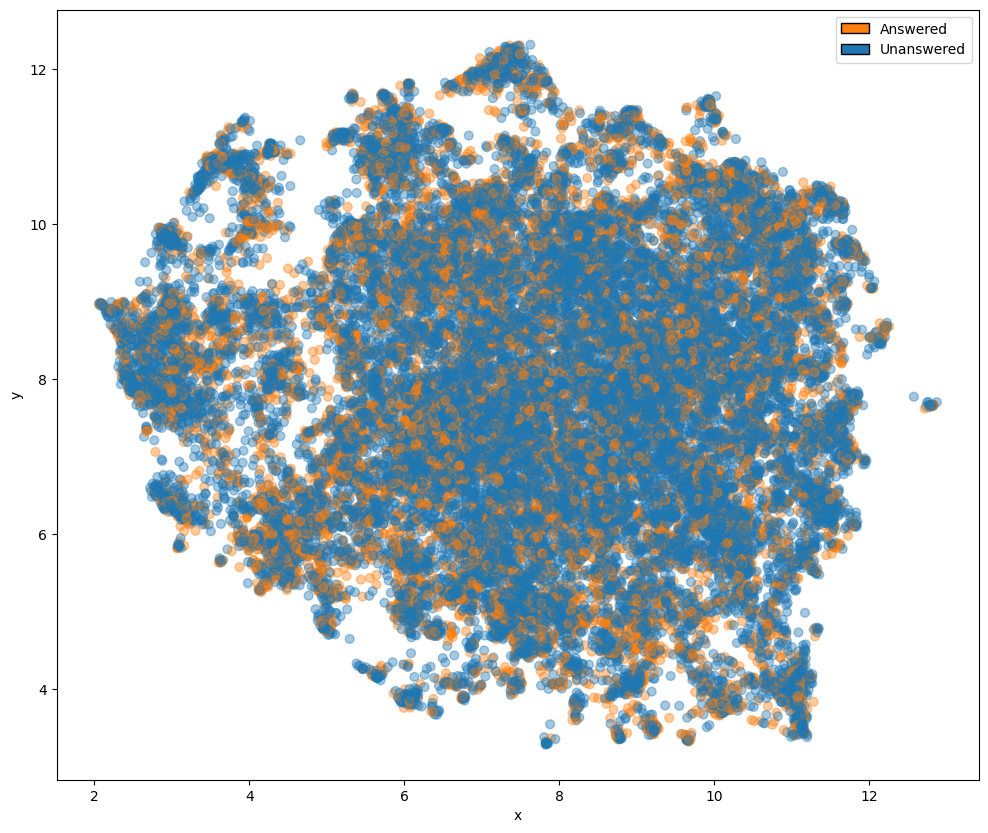

In [6]:
umap_BOW = UMAP_embedding.fit_transform(datascience_posts_BOW)
plot_embeddings(umap_BOW, sentence_labels)

### Spacy

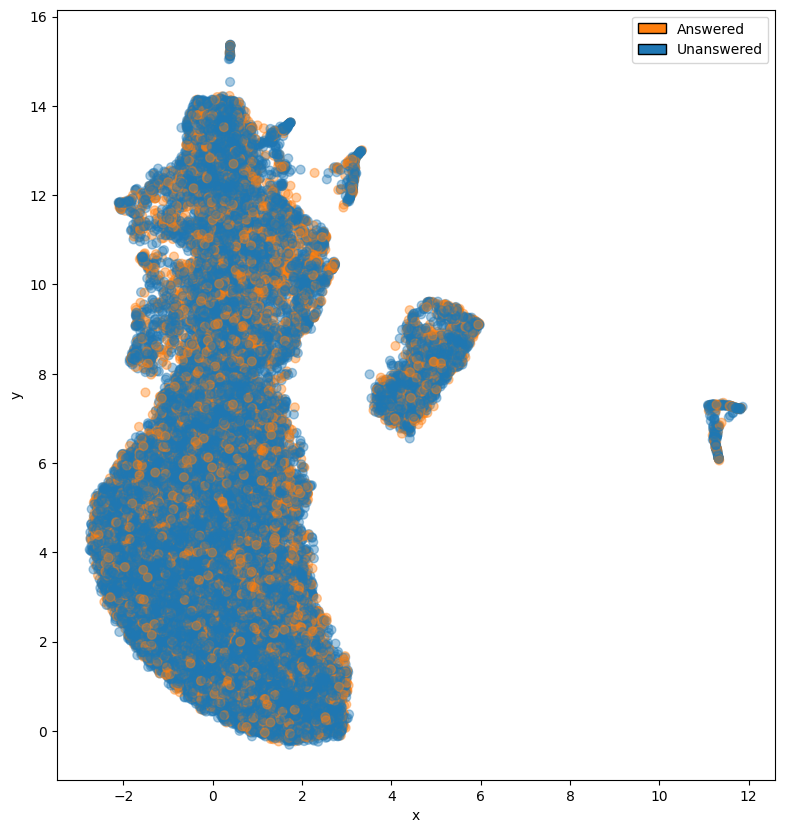

In [7]:
umap_spacy = UMAP_embedding.fit_transform(np.vstack(spacy_embeddings))
plot_embeddings(umap_spacy, sentence_labels)

# Clustering

Text(0.5, 1.0, 'UMAP projection of questions, coloured by clusters')

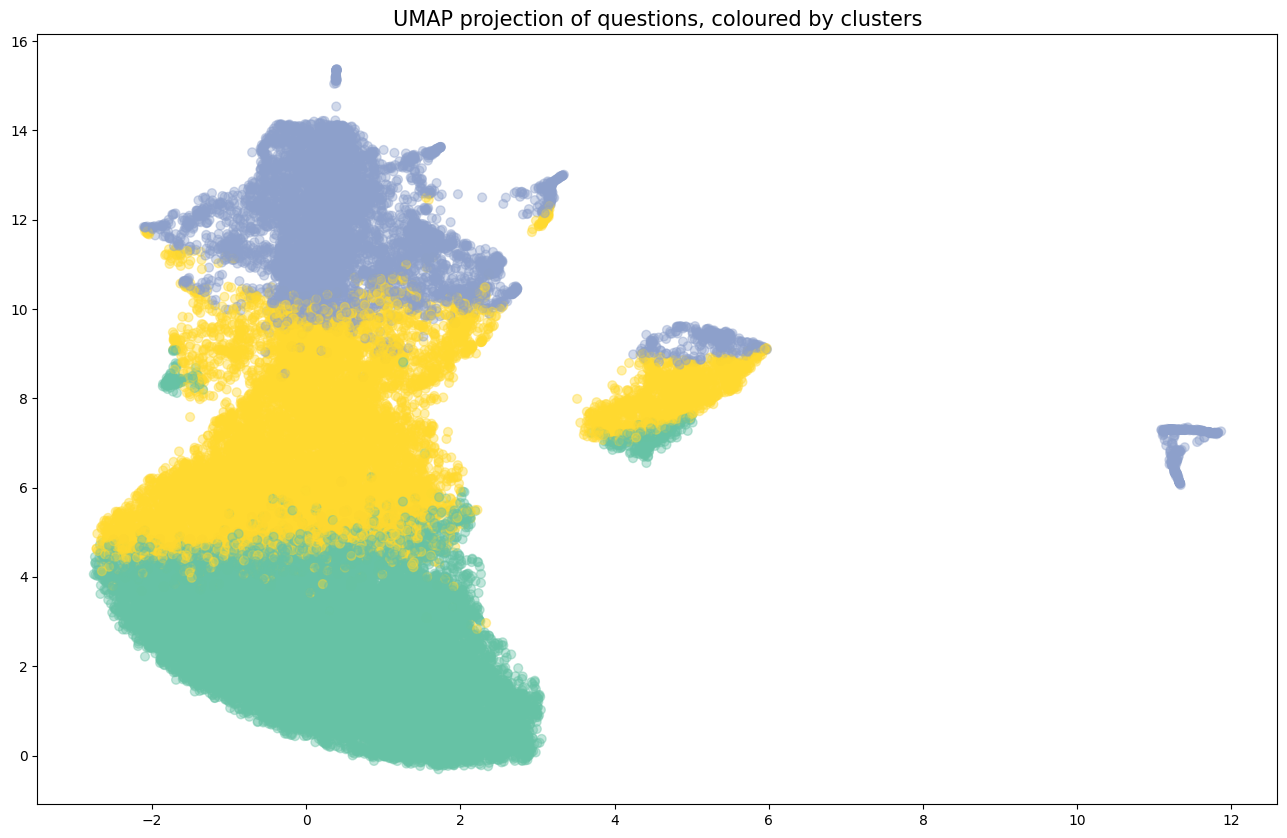

In [8]:
plt.figure(figsize=(16, 10))
cmap = plt.get_cmap('Set2')
clusters = KMeans(n_clusters = 3, random_state = 10).fit_predict(np.vstack(spacy_embeddings))
plt.scatter(umap_spacy[:, 0], umap_spacy[:, 1], c = [cmap(x/3) for x in clusters], s = 40, alpha = 0.4)
plt.title('UMAP projection of questions, coloured by clusters', fontsize = 15)

# Feature Generation

In [9]:
from helper_functions import get_normalised_series

additional_features_df = datascience_posts_df.copy()
additional_features_df['question_mark'] = additional_features_df['body_text'].str.contains('?', regex = False)
print(additional_features_df['question_mark'].value_counts())

additional_features_df['question_word'] = (additional_features_df['body_text'].str.contains('what', regex = False) |
                                            additional_features_df['body_text'].str.contains('how', regex = False) |
                                            additional_features_df['body_text'].str.contains('where', regex = False))
print(additional_features_df['question_word'].value_counts())

additional_features_df['action_verb'] = (additional_features_df['body_text'].str.contains('can', regex = False) |
                                         additional_features_df['body_text'].str.contains('will', regex = False))
print(additional_features_df['action_verb'].value_counts())

additional_features_df['text_length'] = additional_features_df['body_text'].str.len()
additional_features_df['normalised_text_length'] = get_normalised_series(additional_features_df, 'text_length')

question_mark
False    42968
True     35790
Name: count, dtype: int64
question_word
False    39630
True     39296
Name: count, dtype: int64
action_verb
True     46795
False    32131
Name: count, dtype: int64


In [10]:
additional_features_questions_df = additional_features_df[additional_features_df['is_question']][
    ['question_mark', 'question_word', 'action_verb', 'normalised_text_length']]

vectorised_features = np.append(np.vstack(spacy_embeddings), additional_features_questions_df, axis = 1)
vectorised_features.shape

(36775, 304)

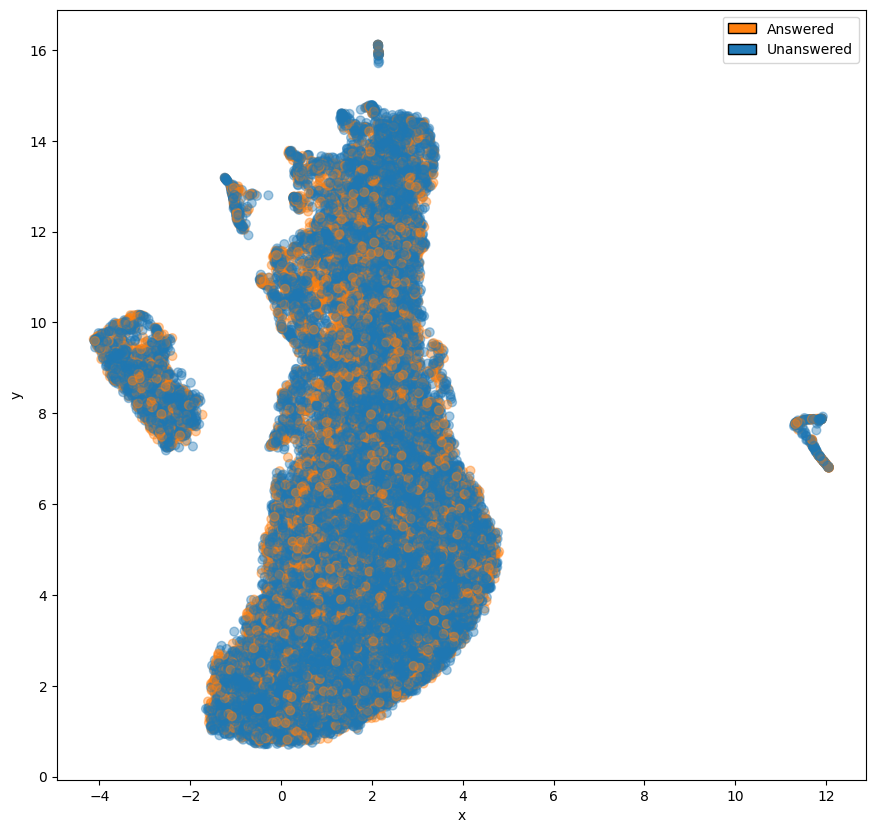

In [11]:
umap_features = UMAP_embedding.fit_transform(vectorised_features)
plot_embeddings(umap_features, sentence_labels)